In [2]:
import numpy as np
import matplotlib.pyplot as plt
from collections import namedtuple

## U.S. Historical Climatology Network (USHCN)
The U.S. Historical Climatology Network (USHCN) data are used to quantify national- and regional-scale temperature changes in the contiguous United States (CONUS). The USHCN is a designated subset of the NOAA Cooperative Observer Program (COOP) Network with sites selected according to their spatial coverage, record length, data completeness, and historical stability.

* raw (`*raw*`) - raw monthly average temperature from weather stations
* curated (`*.FLs.52j.*`) - USHCN Version 2.5.5 homogenized data are associated with the naming convention "52j" to reflect the version of the Pairwise Homogenization Algorithm used.

In [3]:
DATADIR='../data/ushcn.v2.5.5.20180322'
STATIONS='../data/ushcn-v2-stations.txt'

### Stations file format

    011084  31.0581  -87.0547   25.9 AL BREWTON 3 SSE                  ------ ------ ------ +6
    0----+----1----+----2----+----3----+----4----+----5----+----6----+----7----+----8----+----
    statio      lat       lon  heigh st stationname___________________ alias1 alias2 alias3 tz

In [4]:
Station=namedtuple('Station',['id','lat','lon','h','state','name','aliases','tz'])

In [5]:
def read_stations_data(filename):
    stations=[]
    for line in open(filename, "r"):
        s = Station(
            id=line[0:6],
            lat=float(line[8:15]),
            lon=float(line[16:25]),
            h=float(line[26:32]),
            state=line[33:35],
            name=line[36:66].strip(),
            aliases=[l for l in [line[67:73], line[74:80], line[81:87]] if l!='------'],
            tz=line[88:90])
        stations.append(s)
    return stations

In [6]:
stations = read_stations_data(STATIONS)
len(stations)

1218

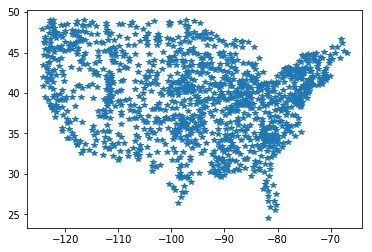

In [7]:
lon = np.array([sta.lon for sta in stations])
lat = np.array([sta.lat for sta in stations])
plt.plot(lon,lat,'*')

### Average temperature file format

    USH00011084 1928   758b    1108     1571     1696     2207     2595     2834     2821     2442E    2082E    1350E     994E 
    USH00011084 1928   800b    1135     1614     1711     2218     2596     2829     2817    -9999    -9999    -9999    -9999
    0----+----1----+----2----+----3----+----4----+----5----+----6----+----7----+----8----+----9----+----0----+----1----+----2
    ?????statio year   janF     febF ....
    
* All the temperatures are in °C
* F - flags ("E" means estimated, there are some other flags)
* -9999 means unknown

In [9]:
MonthlyData = namedtuple('MonthlyData',
    ['id', 'first_year', 'last_year', 'values', 'flags'])

In [10]:
def read_monthly_file(filename):
    lines = open(filename).readlines()
    y1=int(lines[0][12:16])
    y2=int(lines[-1][12:16])
    values = np.full((y2-y1+1, 12), float('NaN'), dtype=np.float32)
    flags = np.zeros((y2-y1+1, 12), dtype=np.byte)
    for l in lines:
        y = int(l[12:16])-y1
        for m in range(12):
            v=int(l[17+m*9:22+m*9])
            f=l[23+m*9]
            if v!=-9999:
                values[y,m] = v/100.0
            flags[y,m] = ord(f)
    return MonthlyData(id=lines[0][5:11], first_year=y1, last_year=y2, values=values, flags=flags)


In [11]:
def read_all_data(y1=1900, y2=2010):
    raw = np.full((len(stations), y2-y1+1, 12), float('NaN'), dtype=np.float32)
    curated = np.full((len(stations), y2-y1+1, 12), float('NaN'), dtype=np.float32)
    for i,s in enumerate(stations):
        mraw=read_monthly_file(DATADIR + "/USH00"+s.id+".raw.tavg")
        mcurated=read_monthly_file(DATADIR + "/USH00"+s.id+".FLs.52j.tavg")
        ry1,ry2 = mraw.first_year,mraw.last_year
        iy1,iy2=max(y1,ry1),min(y2,ry2)
        raw[i,iy1-y1:iy2-y1+1,:] = mraw.values[iy1-ry1:iy2-ry1+1,:]
        cy1,cy2 = mcurated.first_year,mcurated.last_year
        iy1,iy2=max(y1,cy1),min(y2,cy2)
        curated[i,iy1-y1:iy2-y1+1,:] = mcurated.values[iy1-cy1:iy2-cy1+1,:]
    return raw,curated

In [12]:
first_year,last_year=1900,2015
years=np.arange(first_year,last_year+1)
raw,curated=read_all_data(first_year,last_year)

In [13]:
raw.shape,curated.shape

((1218, 116, 12), (1218, 116, 12))

### Difference between raw and curated data as function of year
For cells where we have both raw and curated data, find the difference, and average per year.

In [14]:
yearly_diff=np.nanmean(curated-raw,axis=(0,2))

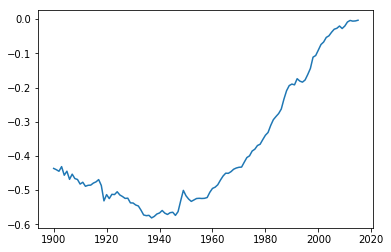

In [15]:
plt.plot(years,yearly_diff)

<Container object of 3 artists>

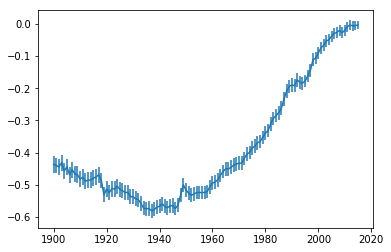

In [16]:
yearly_std=np.nanstd(curated-raw,axis=(0,2))/np.sqrt(len(stations))
plt.errorbar(years,yearly_diff,yearly_std)

### Number of holes in the raw data, as function of year
In the beginning, the number of holes is going down as expected, probably because new stations are built. Starting from ~1990 the stations start to disappear (which coincides with GW)

In [17]:
yearly_holes=np.sum(np.isnan(raw), axis=(0,2))

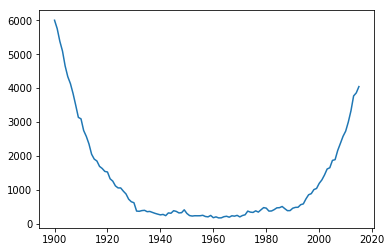

In [18]:
plt.plot(years,yearly_holes)

#### Number of the stations alive for the whole year

In [19]:
alive_stations = np.sum(np.isnan(raw),axis=2)==0
num_alive_stations = np.sum(alive_stations, axis=0)

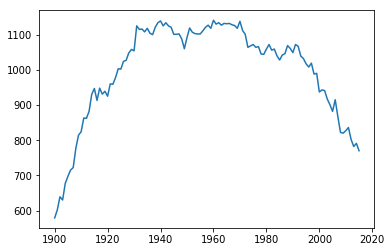

In [20]:
plt.plot(years,num_alive_stations)

### Geographic distribution (average latitude and longitude) of alive stations per year
The average latitude is going up and then down.
The average longitude is going left and then right.

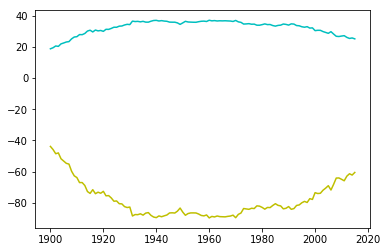

In [21]:
s_lat = np.dot(np.transpose(alive_stations), lat) / len(stations)
s_lon = np.dot(np.transpose(alive_stations), lon) / len(stations)
plt.plot(years,s_lat,'c',years,s_lon,'y')

#### 1950 temperature on the station vs its life status
Early stations are mostly located in warm regions; after 1990, "warm" stations are getting closed.

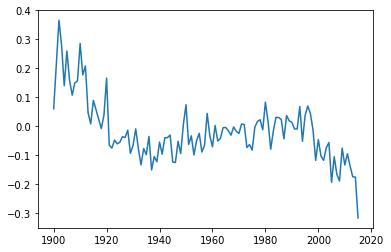

In [22]:
# 1950±10 average temp per station
avg_1950=np.nanmean(raw[:,1940-first_year:1960-first_year,:], axis=(1,2))
avgavg = np.mean(avg_1950)
fate_by_avg_1950=np.dot(avg_1950-avgavg,alive_stations)/np.sum(alive_stations,axis=0)
plt.plot(years,fate_by_avg_1950)

#### Just for fun - scatter plot of stations with average temperatures

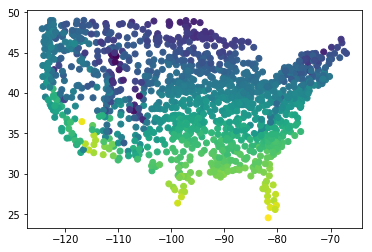

In [23]:
plt.scatter(lon,lat, c=avg_1950)

Are stations different? Checking the theory is that some class of stations could have higher correction than another.

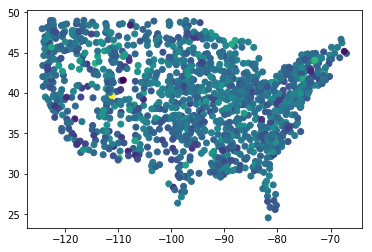

In [25]:
delta_1950=np.nanmean((raw-curated)[:,1940-first_year:1960-first_year,:], axis=(1,2))
plt.scatter(lon,lat, c=delta_1950)

In [31]:
delta_2000=np.nanmean((raw-curated)[:,1990-first_year:,:], axis=(1,2))
plt.scatter(np.choose(lon,isgood),np.choose(lat,isgood), c=delta_2000)

/home/mvr/.local/lib/python3.5/site-packages/ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice
  """Entry point for launching an IPython kernel.


TypeError: Cannot cast array data from dtype('float64') to dtype('int64') according to the rule 'safe'

#### Mapping the dead and alive stations per year

In [22]:
alive_stations.shape

(1218, 116)

In [23]:
def map_dead_alive(year):
    yi = year-first_year
    alive_s = [s for i,s in enumerate(stations) if alive_stations[i,yi]]
    dead_s = [s for i,s in enumerate(stations) if not alive_stations[i,yi]]
    plt.plot([s.lon for s in alive_s],[s.lat for s in alive_s], 'g*',
             [s.lon for s in dead_s],[s.lat for s in dead_s], 'k+')

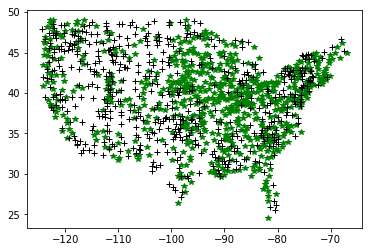

In [24]:
map_dead_alive(1905)

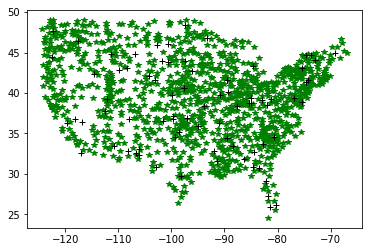

In [25]:
map_dead_alive(1960)

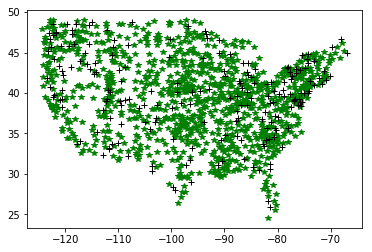

In [26]:
map_dead_alive(1995)

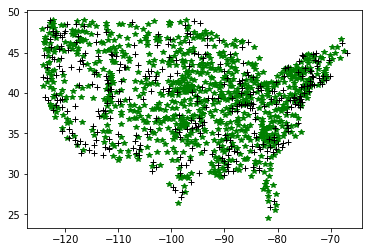

In [27]:
map_dead_alive(2005)

### Average raw vs curated yearly temperature
This is a naïve approach, just average of all known data.
Raw is red, curated is green.

In [28]:
naive_avg_raw = np.nanmean(raw, axis=(0,2))
naive_avg_curated = np.nanmean(curated, axis=(0,2))

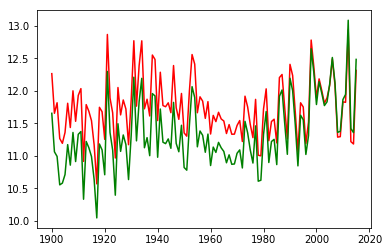

In [29]:
plt.plot(years,naive_avg_raw,'r', years,naive_avg_curated,'g')

#### Five year moving average of the above

In [30]:
def moving_average(a, n=5):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n-1:] / n
ma_raw=moving_average(naive_avg_raw)
ma_curated=moving_average(naive_avg_curated)

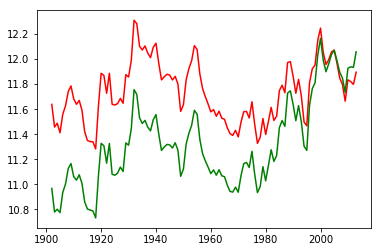

In [31]:
plt.plot(years[2:-2], ma_raw,'r', years[2:-2], ma_curated, 'g')

#### Adding a correction for alive stations distribution

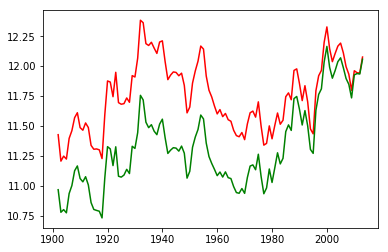

In [32]:
plt.plot(years[2:-2], moving_average(naive_avg_raw - fate_by_avg_1950), 'r', years[2:-2], ma_curated, 'g')